In [ ]:
import pandas as pd
import numpy as np
import re

In [ ]:
df_master=pd.read_csv("/content/merged_kreisdaten.csv")

In [ ]:
def calculate_pkw_anteile(df: pd.DataFrame) -> pd.DataFrame:
    """
    Berechnet für jeden Kreis die Anteile der PKW-Klassen bezogen auf pkw_gesamt.
    Gibt ein neues DataFrame mit 'kreis_id', 'kreis_name' und den Anteilen zurück.
    """
    df_out = df[["kreis_id", "kreis_name"]].copy()

    pkw_klassen = [
        "pkw_benzin", "pkw_diesel", "pkw_elektrisch",
        "pkw_hybrid", "pkw_plugin", "pkw_gas", "pkw_sonstige"
    ]

    for col in pkw_klassen:
        df_out[f"{col}_anteil"] = df[col] / df["pkw_gesamt"]

    return df_out

In [ ]:
def calculate_pro_kopf_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Gibt ein neues DataFrame mit allen Pro-Kopf-Werten zurück.
    Alle Spalten außer 'kreis_id', 'kreis_name' und 'bev_total_2024' werden durch 'bev_total_2024' geteilt.
    """
    # Diese bleiben erhalten
    keep_cols = ["kreis_id", "kreis_name", "bev_total_2024"]

    # Relevante numerische Spalten identifizieren
    num_cols = [col for col in df.columns if col not in keep_cols and pd.api.types.is_numeric_dtype(df[col])]

    # Pro-Kopf-Werte berechnen
    df_pro_kopf = df[["kreis_id", "kreis_name"]].copy()
    for col in num_cols:
        df_pro_kopf[col + "_pro_kopf"] = df[col] / df["bev_total_2024"]

    return df_pro_kopf

In [ ]:
df_pro_kopf = calculate_pro_kopf_df(df_master)
df_pro_kopf.head()

,kreis_id,kreis_name,m_u18_pro_kopf,w_u18_pro_kopf,m_18_34_pro_kopf,w_18_34_pro_kopf,m_35_59_pro_kopf,w_35_59_pro_kopf,m_60_74_pro_kopf,w_60_74_pro_kopf,...,pkw_benzin_pro_kopf,pkw_diesel_pro_kopf,pkw_elektrisch_pro_kopf,pkw_hybrid_pro_kopf,pkw_plugin_pro_kopf,pkw_gas_pro_kopf,pkw_sonstige_pro_kopf,pkw_gesamt_pro_kopf,entgelt_2023_pro_kopf,entgelt_2023_bip_pro_kopf
0,1001.0,"Flensburg, kreisfreie Stadt",0.079646,0.075795,0.133183,0.129840,0.159760,0.153728,0.078951,0.085740,...,0.531944,0.321928,0.035878,0.043581,0.016673,0.004775,0.000332,0.955111,0.028102,0.051388
1,1002.0,"Kiel, kreisfreie Stadt",0.074825,0.072645,0.141522,0.140797,0.157190,0.153672,0.075205,0.085060,...,0.533198,0.259344,0.028670,0.040068,0.016512,0.005153,0.000119,0.883064,0.034603,0.057574
2,1003.0,"Lï¿½beck, kreisfreie Stadt",0.078229,0.071119,0.108023,0.106672,0.159183,0.165877,0.086533,0.099558,...,0.590274,0.260299,0.028060,0.045148,0.017834,0.006436,0.000101,0.948153,0.029010,0.057947
3,1004.0,"Neumï¿½nster, kreisfreie Stadt",0.083061,0.076858,0.111429,0.094626,0.166623,0.160621,0.089464,0.098686,...,0.651781,0.343921,0.037991,0.051147,0.018444,0.007443,0.000150,1.110877,0.030347,0.055533
4,1051.0,"Dithmarschen, Landkreis",0.079987,0.077297,0.092252,0.082654,0.159793,0.159381,0.106938,0.113562,...,0.706339,0.466717,0.035486,0.043054,0.012738,0.006399,0.000225,1.270958,0.018597,0.046149


In [ ]:
df_pkw_anteile = calculate_pkw_anteile(df_master)
df_pkw_anteile.head()

,kreis_id,kreis_name,pkw_benzin_anteil,pkw_diesel_anteil,pkw_elektrisch_anteil,pkw_hybrid_anteil,pkw_plugin_anteil,pkw_gas_anteil,pkw_sonstige_anteil
0,1001.0,"Flensburg, kreisfreie Stadt",0.556944,0.337058,0.037564,0.045629,0.017456,0.005000,0.000348
1,1002.0,"Kiel, kreisfreie Stadt",0.603804,0.293687,0.032467,0.045374,0.018698,0.005835,0.000134
2,1003.0,"Lï¿½beck, kreisfreie Stadt",0.622552,0.274533,0.029595,0.047616,0.018809,0.006788,0.000107
3,1004.0,"Neumï¿½nster, kreisfreie Stadt",0.586727,0.309594,0.034199,0.046042,0.016603,0.006700,0.000135
4,1051.0,"Dithmarschen, Landkreis",0.555753,0.367217,0.027921,0.033875,0.010022,0.005035,0.000177


In [ ]:
# ============================================================
# Wissenschaftlich saubere Regressionsanalyse (Kreisebene)
# Ziel: Treiber der E-Auto-Verbreitung, OHNE kompositionelle Anteile
# ------------------------------------------------------------
# Warum nicht Benzin-/Diesel-Anteile?
#   Kraftstoff-ANTEILE sind kompositionelle Daten (summieren sich ~ auf 1).
#   Wenn du den E-Anteil erklärst und gleichzeitig Benzin-/Diesel-Anteil als
#   Prädiktoren nutzt, entsteht ein mechanischer Zusammenhang: Mehr Benzin
#   bedeutet automatisch weniger Elektro (und umgekehrt). Das produziert:
#     - künstlich hohes R²
#     - instabile Koeffizienten / Vorzeichenwechsel
#     - Multikollinearität
#
# Deshalb modellieren wir stattdessen:
#   (A) E-Autos pro Kopf (Adoption-Intensität)
#   (B) E-Auto-Anteil an allen PKW (Kompositionsgröße), aber OHNE andere Anteile
#
# Wir nutzen robuste Standardfehler (HC3), damit Heteroskedastizität
# (typisch bei Kreisdaten) die Inferenz weniger verzerrt.
# ============================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm

# -----------------------------
# 0) Datenbasis wählen
# -----------------------------
# Erwartung: df_master enthält absolute Größen und/oder df_pro_kopf enthält *_pro_kopf.
# Du hast bereits df_pro_kopf und df_pkw_anteile. Wir bauen eine Analyse-Tabelle daraus.

# Falls df_pro_kopf bereits PKW pro Kopf etc. enthält und df_pkw_anteile den E-Anteil:
df = df_pro_kopf.merge(
    df_pkw_anteile[["kreis_id", "kreis_name", "pkw_elektrisch_anteil"]],
    on=["kreis_id", "kreis_name"],
    how="inner"
).copy()

# -----------------------------
# 1) Zielvariablen definieren
# -----------------------------
# (A) Adoption-Intensität: E-Autos pro Kopf
#     -> weniger "mechanisch" als ein Anteil, gut interpretierbar
y_adoption = "pkw_elektrisch_pro_kopf"

# (B) Kompositionsziel: E-Anteil an allen PKW
#     -> interpretierbar, aber bleibt eine Anteilvariable (0..1)
y_share = "pkw_elektrisch_anteil"

# -----------------------------
# 2) Prädiktoren wählen (ohne Benzin/Diesel-Anteile)
# -----------------------------
# Minimal sinnvolle Struktur:
#   - Einkommen pro Kopf (Arbeitsnehmerentgelt pro Kopf)
#   - BIP pro Kopf (oder alternativ: nur eines davon, um Multikollinearität zu senken)
#   - Altersstruktur (Anteile pro Kopf, getrennt nach Kohorten)
#   - Motorisierung: PKW pro Kopf (Kontrollvariable: mehr PKW pro Kopf -> mehr Potenzial)
#
# Hinweis:
#   entgelt_2023_bip_pro_kopf ist bei dir vermutlich BIP pro Kopf (der Name ist etwas schief).
#   Wenn du wirklich "BIP2023_pro_kopf" hast, nimm lieber die sauber benannte Variable.

X_vars = [
    "entgelt_2023_pro_kopf",          # Proxy für Einkommen
    "entgelt_2023_bip_pro_kopf",      # Proxy für Wirtschaftsleistung (BIP) pro Kopf
    "pkw_gesamt_pro_kopf",            # Motorisierung / Autodichte (Kontrolle)
    "m_18_34_pro_kopf", "w_18_34_pro_kopf",
    "m_60_74_pro_kopf", "w_60_74_pro_kopf",
    "m_75plus_pro_kopf", "w_75plus_pro_kopf",
]

# -----------------------------
# 3) Saubere Analyse-Stichprobe bauen
# -----------------------------
# Wir entfernen Kreise mit fehlenden Werten in Ziel oder Prädiktoren
needed_cols = [y_adoption, y_share] + X_vars
df_model = df.dropna(subset=needed_cols).copy()

# Optional: Extremwerte abfangen (nur falls nötig)
# df_model = df_model[(df_model[y_adoption] >= 0) & (df_model[y_share].between(0,1))]

print("N (Analyse-Stichprobe):", len(df_model))

# -----------------------------
# 4) OLS-Funktion mit robusten Standardfehlern (HC3)
# -----------------------------
def fit_ols_robust(df_in: pd.DataFrame, y: str, X_list: list[str]):
    """
    Schätzt ein lineares OLS-Modell mit robusten Standardfehlern (HC3).
    Gibt Modellobjekt zurück + eine kompakte, 'paper-taugliche' Ergebnis-Tabelle.
    """
    X = df_in[X_list].astype(float)
    X = sm.add_constant(X)  # Intercept
    yv = df_in[y].astype(float)

    model = sm.OLS(yv, X).fit(cov_type="HC3")  # robuste SE
    # Ergebnis-Tabelle: Koeff, SE, t, p, CI
    res = pd.DataFrame({
        "coef": model.params,
        "std_err(HC3)": model.bse,
        "t": model.tvalues,
        "p": model.pvalues,
        "ci_low": model.conf_int().iloc[:, 0],
        "ci_high": model.conf_int().iloc[:, 1],
    })
    return model, res

# -----------------------------
# 5) Modell A: E-Autos pro Kopf (Adoption)
# -----------------------------
model_A, table_A = fit_ols_robust(df_model, y_adoption, X_vars)

print("\n" + "="*80)
print("MODELL A: Determinanten von E-Autos pro Kopf (Adoption-Intensität)")
print("OLS mit robusten Standardfehlern (HC3), Kreisebene")
print("="*80)
print(model_A.summary())

print("\nErgebnistabelle (HC3 robust):")
display(table_A)

# Interpretation-Hinweise (als Kommentar, direkt wissenschaftlich verwendbar):
# - Ein positives Vorzeichen bei entgelt_2023_pro_kopf bedeutet: Kreise mit höherem Einkommen
#   weisen (ceteris paribus) mehr E-Autos pro Einwohner auf.
# - pkw_gesamt_pro_kopf kontrolliert Motorisierung: ohne diese Kontrolle könnte Einkommen nur
#   "mehr Autos insgesamt" abbilden. Mit Kontrolle wird es eher "Elektrifizierung" im engeren Sinn.
# - Alterskohorten interpretierst du als Strukturvariablen: höhere Anteile 60+ sollten typischerweise
#   mit geringerer Adoption zusammenhängen (Neuwagenanteil, Präferenzen etc.).

# -----------------------------
# 6) Modell B: E-Anteil an allen PKW (ohne andere Anteile)
# -----------------------------
model_B, table_B = fit_ols_robust(df_model, y_share, X_vars)

print("\n" + "="*80)
print("MODELL B: Determinanten des E-Auto-Anteils an allen PKW")
print("OLS mit robusten Standardfehlern (HC3), Kreisebene")
print("Hinweis: Ziel ist ein Anteil (0..1). Interpretation als lineares Wahrscheinlichkeitsmodell.")
print("="*80)
print(model_B.summary())

print("\nErgebnistabelle (HC3 robust):")
display(table_B)

# -----------------------------
# 7) Optional: Multikollinearität checken (VIF)
# -----------------------------
# Einkommen und BIP pro Kopf sind häufig stark korreliert.
# Wenn VIF sehr hoch ist, nimm empirisch lieber NUR eine von beiden Variablen
# (z.B. nur entgelt_2023_pro_kopf ODER nur BIP pro Kopf) oder baue einen Index.

from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = sm.add_constant(df_model[X_vars].astype(float))
vif = pd.DataFrame({
    "variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print("\nVIF-Check (Faustregel: > 5 problematisch, > 10 sehr problematisch):")
display(vif)

# -----------------------------
# 8) Wissenschaftlich "cleaner" Varianten (wenn VIF hoch):
# -----------------------------
# Variante A1: nur Einkommen (ohne BIP)
# Variante A2: nur BIP (ohne Einkommen)
# So kannst du zeigen, dass das Ergebnis robust gegenüber Spezifikationen ist.

X_vars_income_only = [v for v in X_vars if v != "entgelt_2023_bip_pro_kopf"]
X_vars_gdp_only    = [v for v in X_vars if v != "entgelt_2023_pro_kopf"]

model_A1, table_A1 = fit_ols_robust(df_model, y_adoption, X_vars_income_only)
model_A2, table_A2 = fit_ols_robust(df_model, y_adoption, X_vars_gdp_only)

print("\n" + "="*80)
print("ROBUSTHEIT: Modell A1 (nur Einkommen, ohne BIP)")
print("="*80)
print(model_A1.summary())

print("\n" + "="*80)
print("ROBUSTHEIT: Modell A2 (nur BIP, ohne Einkommen)")
print("="*80)
print(model_A2.summary())

# Tipp für wissenschaftlichen Output:
# - Berichte mindestens ein Hauptmodell + 1 Robustheitscheck.
# - Diskutiere Vorzeichen und Größenordnung (Effektstärke) und nicht nur p-Werte.
# - Erwähne Einschränkungen: Querschnittsdaten, mögliche omitted variables (Urbanität, Ladeinfrastruktur, Firmenwagen etc.).


N (Analyse-Stichprobe): 397

MODELL A: Determinanten von E-Autos pro Kopf (Adoption-Intensität)
OLS mit robusten Standardfehlern (HC3), Kreisebene
                               OLS Regression Results                              
Dep. Variable:     pkw_elektrisch_pro_kopf   R-squared:                       0.777
Model:                                 OLS   Adj. R-squared:                  0.772
Method:                      Least Squares   F-statistic:                     119.9
Date:                     Fri, 16 Jan 2026   Prob (F-statistic):          3.63e-106
Time:                             17:23:24   Log-Likelihood:                 1391.3
No. Observations:                      397   AIC:                            -2763.
Df Residuals:                          387   BIC:                            -2723.
Df Model:                                9                                         
Covariance Type:                       HC3                                         
             

,coef,std_err(HC3),t,p,ci_low,ci_high
const,0.035918,0.030737,1.168530,0.242593,-0.024327,0.096162
entgelt_2023_pro_kopf,-0.430482,0.209117,-2.058575,0.039535,-0.840343,-0.020621
entgelt_2023_bip_pro_kopf,0.504651,0.158959,3.174723,0.001500,0.193097,0.816206
pkw_gesamt_pro_kopf,0.053277,0.021989,2.422881,0.015398,0.010179,0.096375
m_18_34_pro_kopf,-0.245957,0.110454,-2.226773,0.025962,-0.462443,-0.029470
w_18_34_pro_kopf,0.114985,0.122583,0.938019,0.348235,-0.125273,0.355242
m_60_74_pro_kopf,-0.622902,0.263233,-2.366353,0.017964,-1.138829,-0.106975
w_60_74_pro_kopf,0.020959,0.216764,0.096688,0.922974,-0.403892,0.445809
m_75plus_pro_kopf,0.953827,0.586759,1.625585,0.104038,-0.196200,2.103853
w_75plus_pro_kopf,-0.703491,0.440447,-1.597222,0.110216,-1.566751,0.159768



MODELL B: Determinanten des E-Auto-Anteils an allen PKW
OLS mit robusten Standardfehlern (HC3), Kreisebene
Hinweis: Ziel ist ein Anteil (0..1). Interpretation als lineares Wahrscheinlichkeitsmodell.
                              OLS Regression Results                             
Dep. Variable:     pkw_elektrisch_anteil   R-squared:                       0.729
Model:                               OLS   Adj. R-squared:                  0.723
Method:                    Least Squares   F-statistic:                     125.7
Date:                   Fri, 16 Jan 2026   Prob (F-statistic):          4.33e-109
Time:                           17:23:24   Log-Likelihood:                 1524.0
No. Observations:                    397   AIC:                            -3028.
Df Residuals:                        387   BIC:                            -2988.
Df Model:                              9                                         
Covariance Type:                     HC3                      

,coef,std_err(HC3),t,p,ci_low,ci_high
const,0.057730,0.022063,2.616580,0.008882,0.014487,0.100973
entgelt_2023_pro_kopf,-0.233335,0.151281,-1.542393,0.122978,-0.529840,0.063170
entgelt_2023_bip_pro_kopf,0.318825,0.094196,3.384712,0.000713,0.134205,0.503445
pkw_gesamt_pro_kopf,0.013476,0.015662,0.860455,0.389539,-0.017220,0.044172
m_18_34_pro_kopf,-0.175735,0.069714,-2.520790,0.011709,-0.312373,-0.039098
w_18_34_pro_kopf,0.116168,0.088974,1.305638,0.191676,-0.058218,0.290553
m_60_74_pro_kopf,-0.360175,0.191758,-1.878280,0.060343,-0.736013,0.015664
w_60_74_pro_kopf,-0.063410,0.161288,-0.393145,0.694212,-0.379529,0.252709
m_75plus_pro_kopf,0.865774,0.425134,2.036475,0.041703,0.032527,1.699021
w_75plus_pro_kopf,-0.646604,0.318479,-2.030284,0.042328,-1.270812,-0.022396



VIF-Check (Faustregel: > 5 problematisch, > 10 sehr problematisch):


,variable,VIF
0,const,931.593031
1,entgelt_2023_pro_kopf,23.407065
2,entgelt_2023_bip_pro_kopf,18.088310
3,pkw_gesamt_pro_kopf,1.663352
4,m_18_34_pro_kopf,12.348295
5,w_18_34_pro_kopf,11.513652
6,m_60_74_pro_kopf,34.753627
7,w_60_74_pro_kopf,39.020378
8,m_75plus_pro_kopf,8.600891
9,w_75plus_pro_kopf,13.155174



ROBUSTHEIT: Modell A1 (nur Einkommen, ohne BIP)
                               OLS Regression Results                              
Dep. Variable:     pkw_elektrisch_pro_kopf   R-squared:                       0.756
Model:                                 OLS   Adj. R-squared:                  0.750
Method:                      Least Squares   F-statistic:                     126.3
Date:                     Fri, 16 Jan 2026   Prob (F-statistic):          4.50e-103
Time:                             17:23:25   Log-Likelihood:                 1373.1
No. Observations:                      397   AIC:                            -2728.
Df Residuals:                          388   BIC:                            -2692.
Df Model:                                8                                         
Covariance Type:                       HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- 1) Analyse-DF bauen (du hast df_pro_kopf und df_pkw_anteile) ---
df = df_pro_kopf.merge(
    df_pkw_anteile[["kreis_id", "kreis_name", "pkw_elektrisch_anteil"]],
    on=["kreis_id", "kreis_name"],
    how="inner"
).copy()

# --- 2) Kohorten zu Gesamtanteilen zusammenfassen (m+w) ---
df["share_u18"]    = df["m_u18_pro_kopf"]    + df["w_u18_pro_kopf"]
df["share_18_34"]  = df["m_18_34_pro_kopf"]  + df["w_18_34_pro_kopf"]
df["share_35_59"]  = df["m_35_59_pro_kopf"]  + df["w_35_59_pro_kopf"]
df["share_60_74"]  = df["m_60_74_pro_kopf"]  + df["w_60_74_pro_kopf"]
df["share_75plus"] = df["m_75plus_pro_kopf"] + df["w_75plus_pro_kopf"]

# Optional: Check, ob die Summen ~1 sind (kleine Rundungsfehler ok)
df["share_sum"] = df[["share_u18","share_18_34","share_35_59","share_60_74","share_75plus"]].sum(axis=1)

# --- 3) Zielvariable wählen ---
y = "pkw_elektrisch_pro_kopf"   # Alternative: "pkw_elektrisch_anteil"

# --- 4) Prädiktoren wählen: NUR eine Wohlstandsvariable ---
wealth = "entgelt_2023_bip_pro_kopf"  # Alternative: "entgelt_2023_pro_kopf"

# Kohorten-Anteile: eine als Referenz weglassen (hier share_35_59)
X_vars = [
    wealth,
    "pkw_gesamt_pro_kopf",
    "share_u18",
    "share_18_34",
    "share_60_74",
    "share_75plus",
]

df_model = df.dropna(subset=[y] + X_vars).copy()
print("N:", len(df_model))

# --- 5) OLS mit robusten SE (HC3) ---
X = sm.add_constant(df_model[X_vars].astype(float))
yv = df_model[y].astype(float)

model = sm.OLS(yv, X).fit(cov_type="HC3")
print(model.summary())

# --- 6) VIF-Check ---
vif = pd.DataFrame({
    "variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print("\nVIF:")
display(vif)

# --- 7) Kompakte Ergebnistabelle ---
res = pd.DataFrame({
    "coef": model.params,
    "std_err(HC3)": model.bse,
    "z": model.tvalues,
    "p": model.pvalues,
    "ci_low": model.conf_int().iloc[:, 0],
    "ci_high": model.conf_int().iloc[:, 1],
})
display(res)


N: 398
                               OLS Regression Results                              
Dep. Variable:     pkw_elektrisch_pro_kopf   R-squared:                       0.735
Model:                                 OLS   Adj. R-squared:                  0.731
Method:                      Least Squares   F-statistic:                     68.42
Date:                     Fri, 16 Jan 2026   Prob (F-statistic):           5.80e-58
Time:                             17:26:42   Log-Likelihood:                 1358.0
No. Observations:                      398   AIC:                            -2702.
Df Residuals:                          391   BIC:                            -2674.
Df Model:                                6                                         
Covariance Type:                       HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

,variable,VIF
0,const,6470.864783
1,entgelt_2023_bip_pro_kopf,1.820936
2,pkw_gesamt_pro_kopf,1.314229
3,share_u18,5.077666
4,share_18_34,13.444063
5,share_60_74,12.736923
6,share_75plus,4.172992


,coef,std_err(HC3),z,p,ci_low,ci_high
const,0.008829,0.047995,0.183950,0.854053,-0.085240,0.102897
entgelt_2023_bip_pro_kopf,0.275273,0.110598,2.488960,0.012812,0.058506,0.492040
pkw_gesamt_pro_kopf,0.053725,0.012472,4.307497,0.000017,0.029280,0.078171
share_u18,0.126553,0.139814,0.905146,0.365388,-0.147479,0.400584
share_18_34,-0.060382,0.039116,-1.543662,0.122670,-0.137049,0.016284
share_60_74,-0.282337,0.085731,-3.293295,0.000990,-0.450367,-0.114308
share_75plus,-0.012109,0.070676,-0.171331,0.863964,-0.150631,0.126413


In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

def zscore(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    return (s - s.mean()) / s.std(ddof=0)

def fit_ols_hc3(df_in: pd.DataFrame, y: str, x_vars: list[str], name: str):
    d = df_in.dropna(subset=[y] + x_vars).copy()
    yv = d[y].astype(float)
    X = d[x_vars].astype(float)
    Xc = sm.add_constant(X)

    model = sm.OLS(yv, Xc).fit(cov_type="HC3")

    # RMSE auf Trainingsdaten (nur Vergleich)
    yhat = model.predict(Xc)
    rmse = float(np.sqrt(mean_squared_error(yv, yhat)))

    # Standardisierte Betas (z-Transform auf y und X)
    yz = zscore(d[y])
    Xz = pd.DataFrame({col: zscore(d[col]) for col in x_vars})
    Xzc = sm.add_constant(Xz)
    model_z = sm.OLS(yz, Xzc).fit(cov_type="HC3")

    out = {
        "name": name,
        "n": len(d),
        "adj_r2": float(model.rsquared_adj),
        "aic": float(model.aic),
        "bic": float(model.bic),
        "rmse": rmse,
        "model": model,
        "model_z": model_z,
        "x_vars": x_vars,
        "df_used": d
    }
    return out

# Indikatorgruppen: getrennte Modelle
wealth_models = [
    ("Wohlstand: Einkommen pro Kopf", ["entgelt_2023_pro_kopf"]),
    ("Wohlstand: BIP pro Kopf", ["entgelt_2023_bip_pro_kopf"]),
]

demo_models = [
    # Referenz weglassen, sonst Kompositionsproblem; wir lassen share_35_59 weg
    ("Demografie: Kohorten (Ref: 35-59)", ["share_u18", "share_18_34", "share_60_74", "share_75plus"]),
]

motor_models = [
    ("Motorisierung: PKW pro Kopf", ["pkw_gesamt_pro_kopf"]),
]

structure_models = [
    # Antriebsstruktur: Anteile; hier NICHT den Elektro-Anteil selbst als X verwenden
    # Referenz: Benzin weglassen, dann sind die Koeffizienten "gegen Benzin"
    ("Antriebsstruktur (Ref: Benzin)", ["pkw_diesel_anteil","pkw_hybrid_anteil","pkw_plugin_anteil","pkw_gas_anteil","pkw_sonstige_anteil"]),
]

# Optional: wenn du einen "kontrollierten" Vergleich willst, baue pro Gruppe ein Modell + Kontrolle Motorisierung
# (immer noch nicht alles vermengen, aber Motorisierung als gemeinsame Kontrolle)
wealth_plus_motor = [
    ("Wohlstand Eink. + Motorisierung", ["entgelt_2023_pro_kopf","pkw_gesamt_pro_kopf"]),
    ("Wohlstand BIP + Motorisierung", ["entgelt_2023_bip_pro_kopf","pkw_gesamt_pro_kopf"]),
]
demo_plus_motor = [
    ("Demografie + Motorisierung", ["share_u18","share_18_34","share_60_74","share_75plus","pkw_gesamt_pro_kopf"]),
]

specs = wealth_models + demo_models + motor_models + structure_models + wealth_plus_motor + demo_plus_motor

results = []
for name, xvars in specs:
    results.append(fit_ols_hc3(df, Y, xvars, name))

# Vergleichstabelle
cmp = pd.DataFrame([{
    "Modell": r["name"],
    "N": r["n"],
    "Adj_R2": r["adj_r2"],
    "RMSE": r["rmse"],
    "AIC": r["aic"],
    "BIC": r["bic"]
} for r in results]).sort_values(["Adj_R2","RMSE"], ascending=[False, True])

cmp


,Modell,N,Adj_R2,RMSE,AIC,BIC
7,Demografie + Motorisierung,400,0.669643,0.008847,-2635.025943,-2611.077156
6,Wohlstand BIP + Motorisierung,398,0.579194,0.010034,-2527.571719,-2515.612363
5,Wohlstand Eink. + Motorisierung,398,0.540346,0.010486,-2492.427566,-2480.468210
4,Antriebsstruktur (Ref: Benzin),399,0.416766,0.011675,-2407.022516,-2383.088747
3,Motorisierung: PKW pro Kopf,400,0.293614,0.013002,-2334.990426,-2327.007497
2,Demografie: Kohorten (Ref: 35-59),400,0.251229,0.013336,-2308.708584,-2288.751261
1,Wohlstand: BIP pro Kopf,398,0.219611,0.013681,-2282.752701,-2274.779797
0,Wohlstand: Einkommen pro Kopf,398,0.133951,0.014412,-2241.301350,-2233.328446


Zelle 3: Koeffizienten-Grafik je Modell (standardisierte Betas mit 95%-CI)

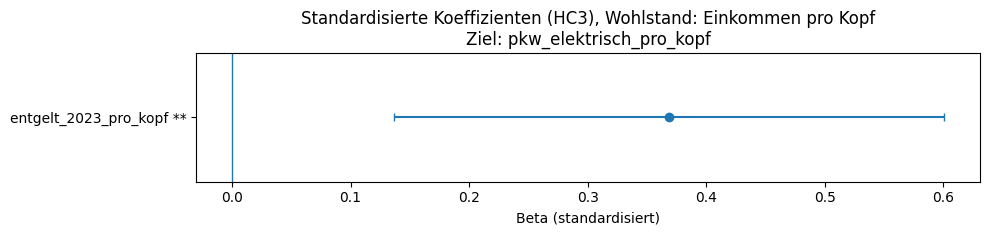

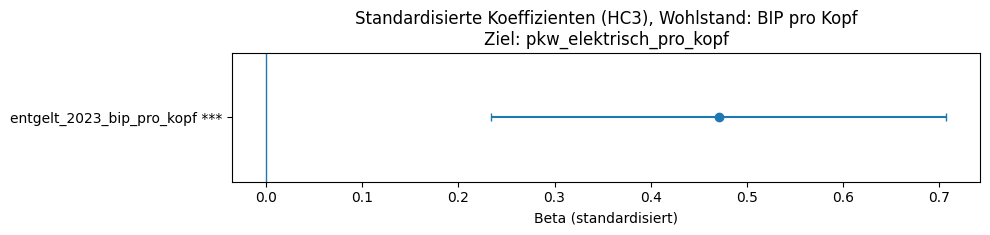

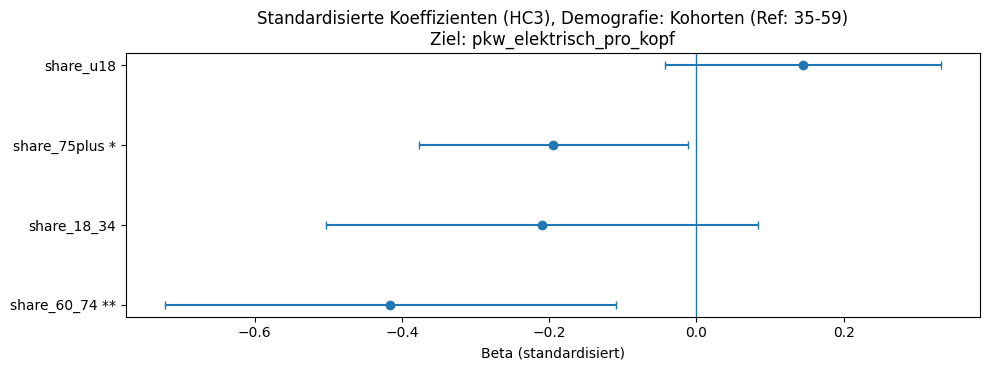

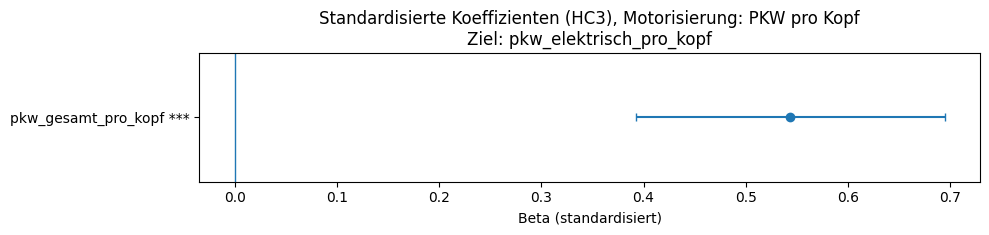

In [ ]:
import matplotlib.pyplot as plt

def coef_plot_standardized(res, max_vars=12):
    m = res["model_z"]
    params = m.params.drop("const", errors="ignore")
    ci = m.conf_int().loc[params.index]
    pvals = m.pvalues.loc[params.index]

    # Sort nach Betrag
    order = params.abs().sort_values(ascending=False).index[:max_vars]
    params = params.loc[order]
    ci = ci.loc[order]
    pvals = pvals.loc[order]

    y = np.arange(len(order))

    plt.figure(figsize=(10, 0.45 * len(order) + 2))
    plt.errorbar(params.values, y, xerr=[
        params.values - ci[0].values,
        ci[1].values - params.values
    ], fmt='o', capsize=3)
    plt.axvline(0, linewidth=1)

    labels = []
    for v in order:
        star = ""
        if pvals[v] < 0.001:
            star = "***"
        elif pvals[v] < 0.01:
            star = "**"
        elif pvals[v] < 0.05:
            star = "*"
        labels.append(f"{v} {star}".strip())

    plt.yticks(y, labels)
    plt.title(f"Standardisierte Koeffizienten (HC3), {res['name']}\nZiel: {Y}")
    plt.xlabel("Beta (standardisiert)")
    plt.tight_layout()
    plt.show()

# Alle Modellplots hintereinander
for r in results:
    coef_plot_standardized(r)


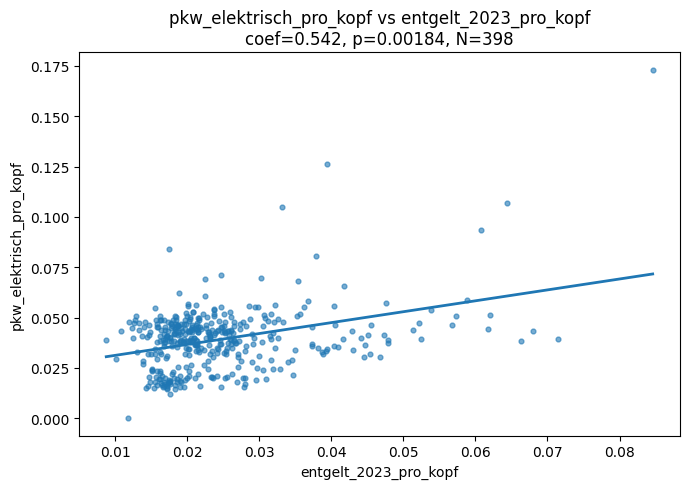

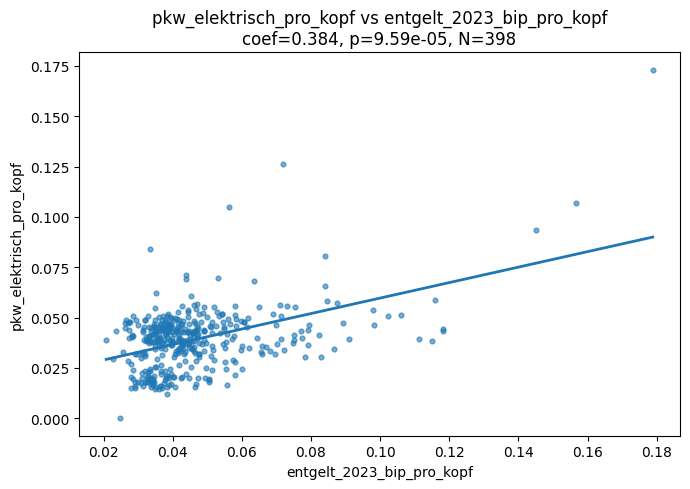

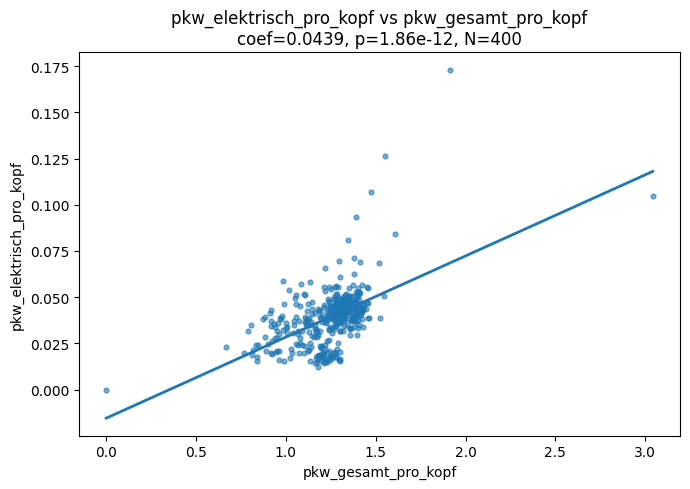

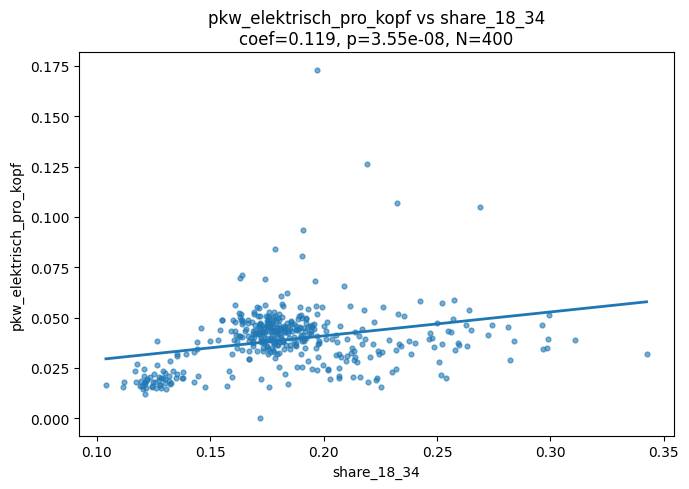

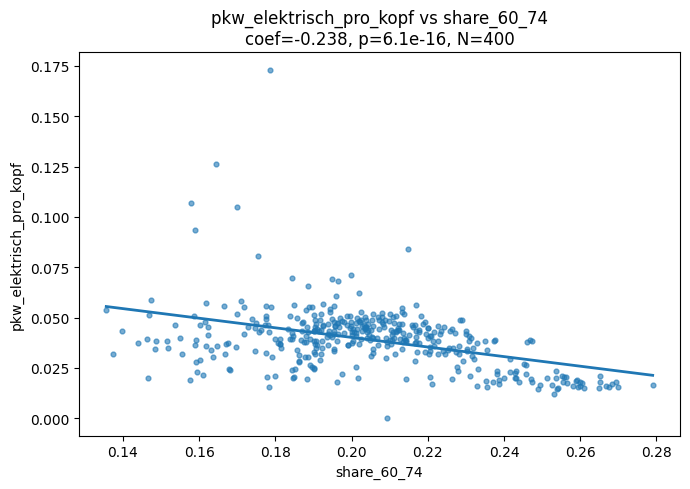

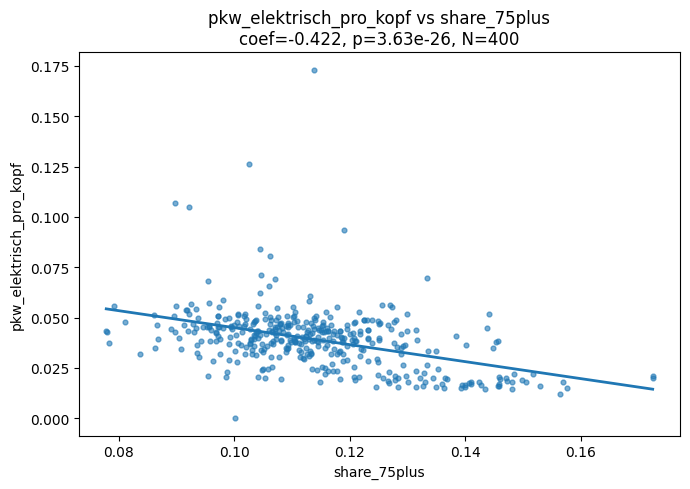

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def scatter_with_fit(df_in, y, x, title=None):
    d = df_in.dropna(subset=[y, x]).copy()
    X = sm.add_constant(d[[x]].astype(float))
    yv = d[y].astype(float)
    m = sm.OLS(yv, X).fit(cov_type="HC3")

    xvals = np.linspace(d[x].astype(float).min(), d[x].astype(float).max(), 200)
    Xp = sm.add_constant(pd.DataFrame({x: xvals}))
    yhat = m.predict(Xp)

    plt.figure(figsize=(7,5))
    plt.scatter(d[x].astype(float), yv, s=12, alpha=0.6)
    plt.plot(xvals, yhat, linewidth=2)
    plt.title(title or f"{y} vs {x}\ncoef={m.params[x]:.3g}, p={m.pvalues[x]:.3g}, N={len(d)}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()
    plt.show()

# Beispiele: Wohlstand, Motorisierung, Demografie-Kohorten
for x in ["entgelt_2023_pro_kopf", "entgelt_2023_bip_pro_kopf", "pkw_gesamt_pro_kopf",
          "share_18_34", "share_60_74", "share_75plus"]:
    scatter_with_fit(df, Y, x)


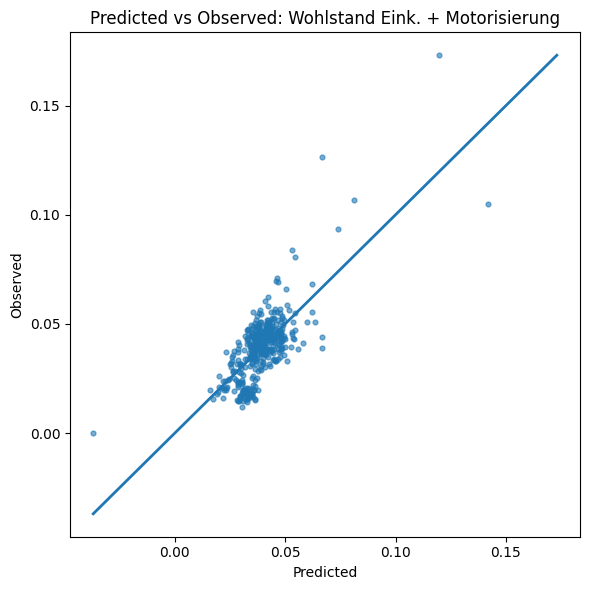

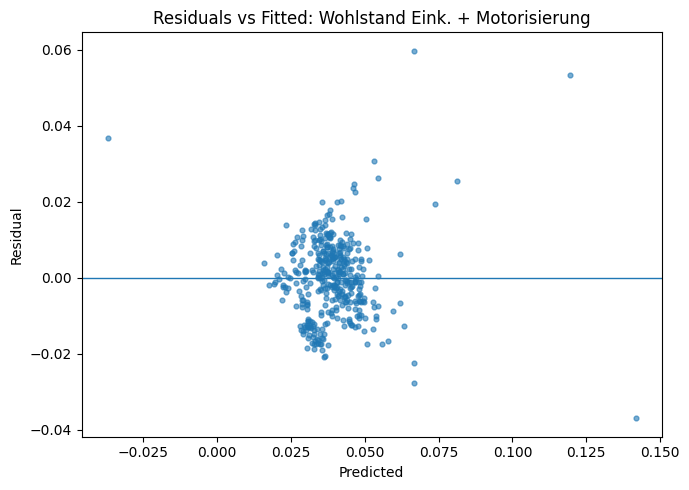

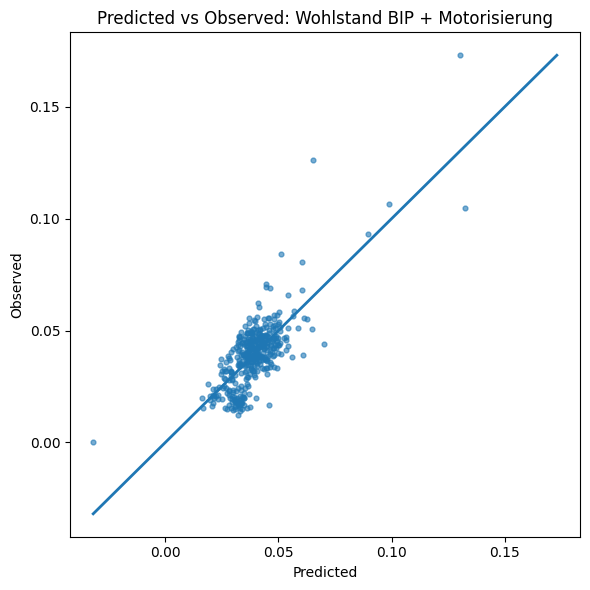

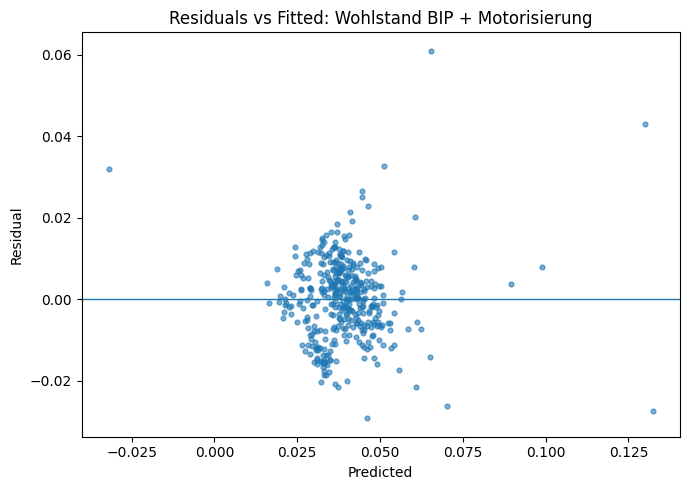

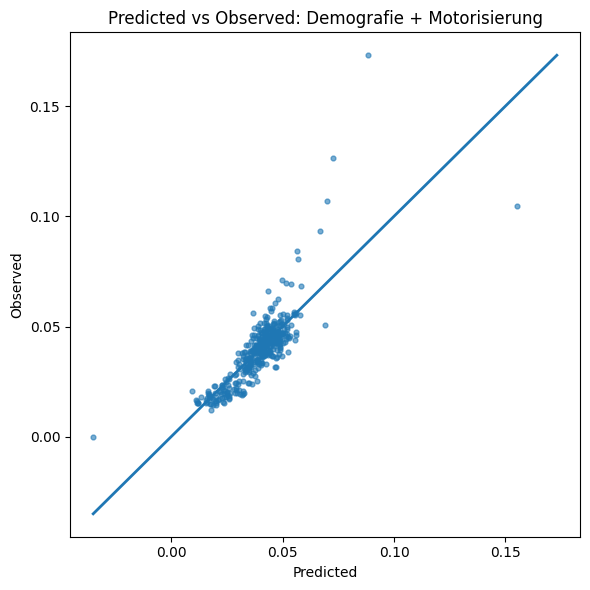

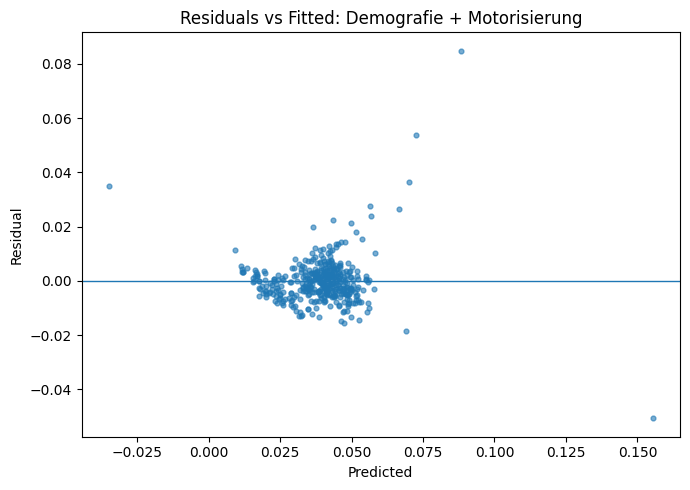

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def diagnostics_plots(res):
    m = res["model"]
    d = res["df_used"]
    xvars = res["x_vars"]

    X = sm.add_constant(d[xvars].astype(float))
    yv = d[Y].astype(float)
    yhat = m.predict(X)
    resid = yv - yhat

    # Predicted vs Observed
    plt.figure(figsize=(6,6))
    plt.scatter(yhat, yv, s=12, alpha=0.6)
    mn = min(yhat.min(), yv.min())
    mx = max(yhat.max(), yv.max())
    plt.plot([mn, mx], [mn, mx], linewidth=2)
    plt.title(f"Predicted vs Observed: {res['name']}")
    plt.xlabel("Predicted")
    plt.ylabel("Observed")
    plt.tight_layout()
    plt.show()

    # Residuals vs Fitted
    plt.figure(figsize=(7,5))
    plt.scatter(yhat, resid, s=12, alpha=0.6)
    plt.axhline(0, linewidth=1)
    plt.title(f"Residuals vs Fitted: {res['name']}")
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.tight_layout()
    plt.show()

# Diagnostics für die besten 3 Modelle nach Adj_R2
top3_names = cmp.sort_values("Adj_R2", ascending=False).head(3)["Modell"].tolist()
for r in results:
    if r["name"] in top3_names:
        diagnostics_plots(r)


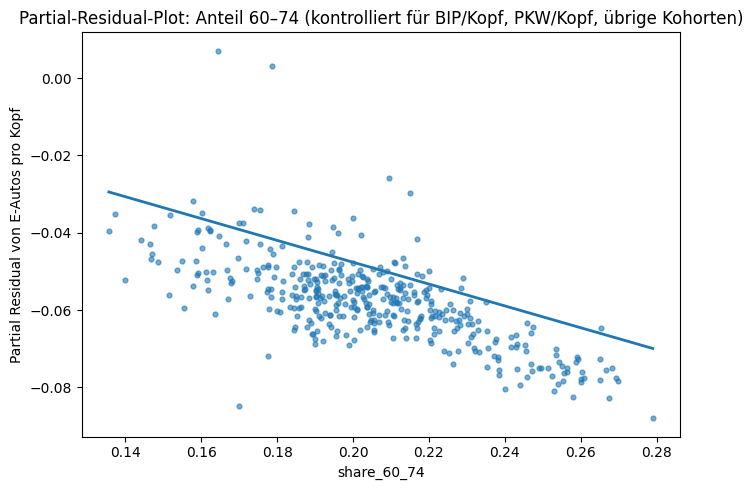

                               OLS Regression Results                              
Dep. Variable:     pkw_elektrisch_pro_kopf   R-squared:                       0.735
Model:                                 OLS   Adj. R-squared:                  0.731
Method:                      Least Squares   F-statistic:                     68.42
Date:                     Fri, 16 Jan 2026   Prob (F-statistic):           5.80e-58
Time:                             17:44:29   Log-Likelihood:                 1358.0
No. Observations:                      398   AIC:                            -2702.
Df Residuals:                          391   BIC:                            -2674.
Df Model:                                6                                         
Covariance Type:                       HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Daten & Spezifikation
Y = "pkw_elektrisch_pro_kopf"
X = ["entgelt_2023_bip_pro_kopf", "pkw_gesamt_pro_kopf", "share_u18", "share_18_34", "share_60_74", "share_75plus"]

d = df.dropna(subset=[Y] + X).copy()
y = d[Y].astype(float)
Xmat = sm.add_constant(d[X].astype(float))

m = sm.OLS(y, Xmat).fit(cov_type="HC3")

# Partial residual für share_60_74:
xvar = "share_60_74"
beta = m.params[xvar]
partial_resid = m.resid + beta * d[xvar].astype(float)

plt.figure(figsize=(7,5))
plt.scatter(d[xvar].astype(float), partial_resid, s=12, alpha=0.6)

# lineare Fit-Linie (nur visual)
xvals = np.linspace(d[xvar].astype(float).min(), d[xvar].astype(float).max(), 200)
plt.plot(xvals, m.params["const"] + beta * xvals, linewidth=2)

plt.title("Partial-Residual-Plot: Anteil 60–74 (kontrolliert für BIP/Kopf, PKW/Kopf, übrige Kohorten)")
plt.xlabel("share_60_74")
plt.ylabel("Partial Residual von E-Autos pro Kopf")
plt.tight_layout()
plt.show()

print(m.summary())


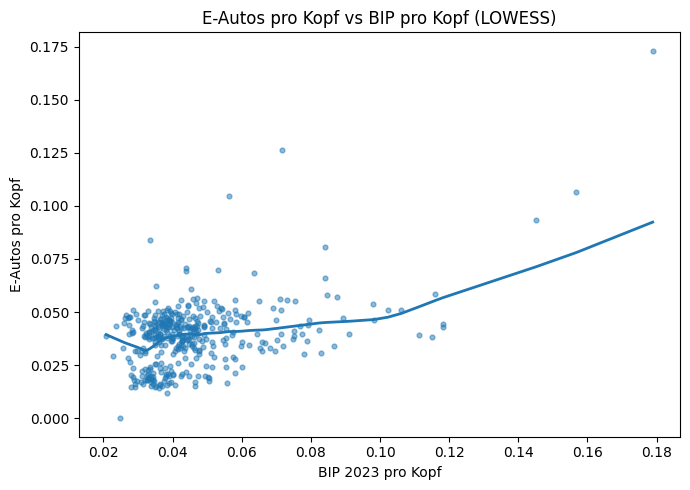

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

x = "entgelt_2023_bip_pro_kopf"
d = df.dropna(subset=[Y, x]).copy()

plt.figure(figsize=(7,5))
plt.scatter(d[x].astype(float), d[Y].astype(float), s=12, alpha=0.5)

lowess = sm.nonparametric.lowess(
    endog=d[Y].astype(float),
    exog=d[x].astype(float),
    frac=0.35
)
plt.plot(lowess[:,0], lowess[:,1], linewidth=2)

plt.title("E-Autos pro Kopf vs BIP pro Kopf (LOWESS)")
plt.xlabel("BIP 2023 pro Kopf")
plt.ylabel("E-Autos pro Kopf")
plt.tight_layout()
plt.show()


Grafik 3: Observed vs Predicted für Top-3 Modelle (jeweils separat)

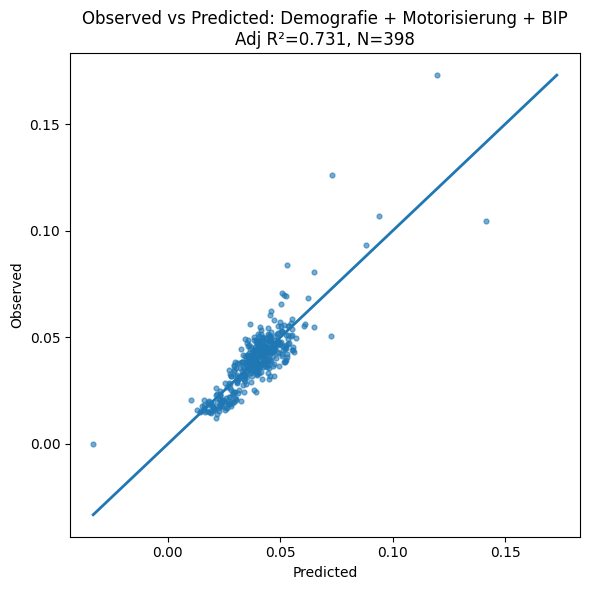

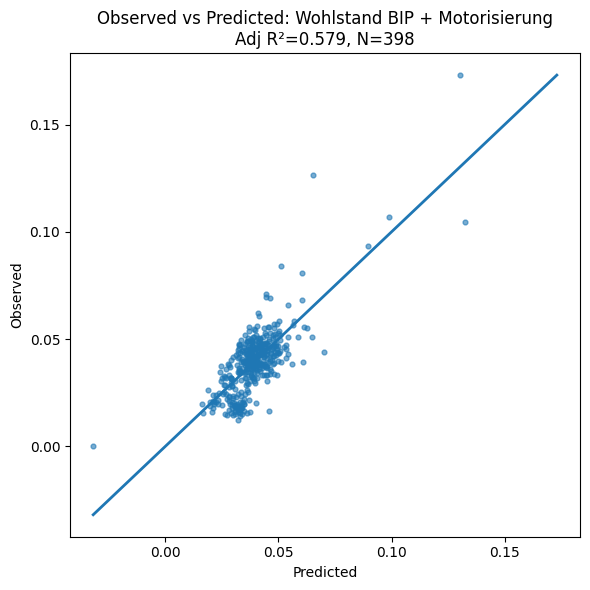

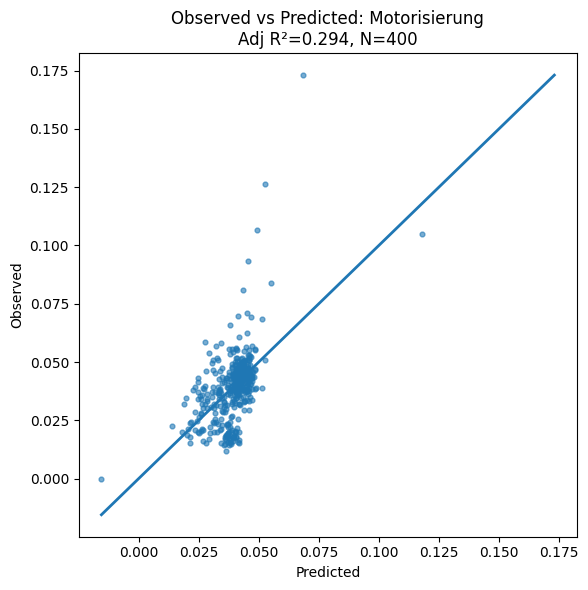

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

def fit_model(y, xvars):
    d = df.dropna(subset=[y] + xvars).copy()
    yv = d[y].astype(float)
    Xv = sm.add_constant(d[xvars].astype(float))
    m = sm.OLS(yv, Xv).fit(cov_type="HC3")
    yhat = m.predict(Xv)
    return d, yv, yhat, m

models = [
    ("Demografie + Motorisierung + BIP", ["entgelt_2023_bip_pro_kopf","pkw_gesamt_pro_kopf","share_u18","share_18_34","share_60_74","share_75plus"]),
    ("Wohlstand BIP + Motorisierung", ["entgelt_2023_bip_pro_kopf","pkw_gesamt_pro_kopf"]),
    ("Motorisierung", ["pkw_gesamt_pro_kopf"]),
]

for name, xvars in models:
    d, yv, yhat, m = fit_model(Y, xvars)

    plt.figure(figsize=(6,6))
    plt.scatter(yhat, yv, s=12, alpha=0.6)

    mn = min(yhat.min(), yv.min())
    mx = max(yhat.max(), yv.max())
    plt.plot([mn, mx], [mn, mx], linewidth=2)

    plt.title(f"Observed vs Predicted: {name}\nAdj R²={m.rsquared_adj:.3f}, N={len(d)}")
    plt.xlabel("Predicted")
    plt.ylabel("Observed")
    plt.tight_layout()
    plt.show()


Grafik 4: Koeffizientenplot (standardisiert) für euer Bestmodell


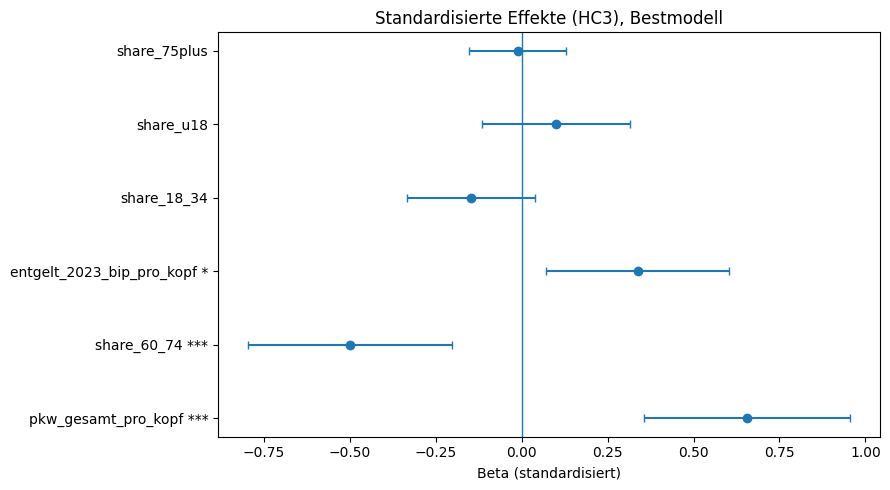

                               OLS Regression Results                              
Dep. Variable:     pkw_elektrisch_pro_kopf   R-squared:                       0.735
Model:                                 OLS   Adj. R-squared:                  0.731
Method:                      Least Squares   F-statistic:                     68.42
Date:                     Fri, 16 Jan 2026   Prob (F-statistic):           5.80e-58
Time:                             17:46:14   Log-Likelihood:                -300.22
No. Observations:                      398   AIC:                             614.4
Df Residuals:                          391   BIC:                             642.3
Df Model:                                6                                         
Covariance Type:                       HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

def zscore(s):
    s = s.astype(float)
    return (s - s.mean()) / s.std(ddof=0)

xvars = ["entgelt_2023_bip_pro_kopf","pkw_gesamt_pro_kopf","share_u18","share_18_34","share_60_74","share_75plus"]
d = df.dropna(subset=[Y] + xvars).copy()

yz = zscore(d[Y])
Xz = pd.DataFrame({c: zscore(d[c]) for c in xvars})
m = sm.OLS(yz, sm.add_constant(Xz)).fit(cov_type="HC3")

params = m.params.drop("const")
ci = m.conf_int().loc[params.index]
pvals = m.pvalues.loc[params.index]

order = params.abs().sort_values(ascending=False).index
ypos = np.arange(len(order))

plt.figure(figsize=(9, 0.5*len(order)+2))
plt.errorbar(params.loc[order].values, ypos,
             xerr=[params.loc[order].values - ci.loc[order,0].values,
                   ci.loc[order,1].values - params.loc[order].values],
             fmt='o', capsize=3)
plt.axvline(0, linewidth=1)

labels = []
for v in order:
    star = ""
    if pvals[v] < 0.001: star = "***"
    elif pvals[v] < 0.01: star = "**"
    elif pvals[v] < 0.05: star = "*"
    labels.append(f"{v} {star}".strip())

plt.yticks(ypos, labels)
plt.title("Standardisierte Effekte (HC3), Bestmodell")
plt.xlabel("Beta (standardisiert)")
plt.tight_layout()
plt.show()

print(m.summary())


In [ ]:
Grafik 5: Cook’s Distance (wer zieht dein Modell)

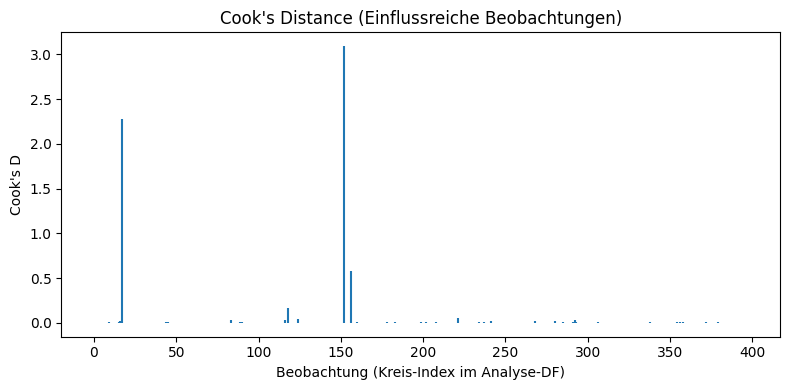

,kreis_id,kreis_name,cooksD
159,7211.0,"Trier, kreisfreie Stadt",3.090713
18,3103.0,"Wolfsburg, kreisfreie Stadt",2.275270
163,7235.0,"Trier-Saarburg, Landkreis",0.579805
125,6414.0,"Wiesbaden, kreisfreie Stadt",0.162933
228,9161.0,"Ingolstadt, kreisfreie Stadt",0.052739
131,6436.0,Main-Taunus-Kreis,0.038764
90,5366.0,"Euskirchen, Landkreis",0.034056
123,6412.0,"Frankfurt am Main, kreisfreie Stadt",0.031395
299,9662.0,"Schweinfurt, kreisfreie Stadt",0.029500
248,9188.0,"Starnberg, Landkreis",0.023635


In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

xvars = ["entgelt_2023_bip_pro_kopf","pkw_gesamt_pro_kopf","share_u18","share_18_34","share_60_74","share_75plus"]
d = df.dropna(subset=[Y] + xvars).copy()
y = d[Y].astype(float)
X = sm.add_constant(d[xvars].astype(float))

m_plain = sm.OLS(y, X).fit()  # diagnostics brauchen oft non-robust fit

infl = m_plain.get_influence()
cooks = infl.cooks_distance[0]

plt.figure(figsize=(8,4))
plt.stem(np.arange(len(cooks)), cooks, markerfmt=" ", basefmt=" ")
plt.title("Cook's Distance (Einflussreiche Beobachtungen)")
plt.xlabel("Beobachtung (Kreis-Index im Analyse-DF)")
plt.ylabel("Cook's D")
plt.tight_layout()
plt.show()

# Top 10 einflussreichste Kreise anzeigen
top_idx = np.argsort(cooks)[-10:][::-1]
d.loc[d.index[top_idx], ["kreis_id","kreis_name"]].assign(cooksD=cooks[top_idx])


In [ ]:

    # 1) Roh einlesen: KEIN Header, weil die Datei mehrere Header-/Infozeilen enthält
raw = pd.read_csv(
        "/Users/felixipfling/Documents/GitHub/codex_start/data/raw/46251-0021_de.csv",
        sep=";",
        header=None,
        encoding="cp1252",
        dtype=str,
        engine="python"  # toleranter bei "komischen" Zeilen
    )
display(raw)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Neuer Abschnitt

In [ ]:
    )
display(raw)